#### The goal of this notebook is to do an ablation study with differnet semantic preicision metrics, to see how they perform and correlate with one another.

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from plotly.subplots import make_subplots
from litQeval.eval_utils import *
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotly.io as pio
import pandas as pd
import numpy as np
import json
pio.templates.default = "seaborn"
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
PLOT_CONFIGS = dict(
    title_x=0.5, title_font_size=30, title_font_family="Modern Computer", font_family="Modern Computer",
    showlegend=False, legend_title="", height=400,
    xaxis_tickfont_size=15, yaxis_tickfont_size=15, legend_font_size=20, legend_itemsizing="constant",
    legend_orientation="h", legend_yanchor="bottom", legend_y=-0.3, legend_xanchor="center", legend_x=0.5
)

In [2]:
topics = [i["baseline"] for i in json.load(open('data/queries.json'))]

### Overview

In [3]:
def create_scatters():
    plot = make_subplots(rows=len(topics)//2, cols=2, subplot_titles=topics)
    for idx, topic in tqdm(enumerate(topics), total=len(topics)):
        data = get_evaluation_data(topic)
        umap_core_embeddings = data["umap_core_embeddings"]
        df = data["df"]

        plot.add_traces([
            go.Scattergl(
                x=df[df["Source"] == "Predicted"]["UMAP1"],
                y=df[df["Source"] == "Predicted"]["UMAP2"],
                mode="markers",
                marker=dict(color=COLORS[0], size=5),
                name="Predicted",
                opacity=0.5,
                showlegend=False,
            ),
            go.Scattergl(
                x=df[df["Source"] == "Baseline"]["UMAP1"],
                y=df[df["Source"] == "Baseline"]["UMAP2"],
                mode="markers",
                marker=dict(color=COLORS[1], size=5),
                name="Baseline",
                opacity=0.5,
                showlegend=False,
            ),
            go.Scattergl(
                x=umap_core_embeddings[:, 0],
                y=umap_core_embeddings[:, 1],
                mode="markers",
                opacity=0.5,
                marker=dict(color="red", size=5),
                showlegend=False,
            ),
        ],
            rows=idx//2+1, cols=idx % 2+1)

    plot.update_layout(height=2000, showlegend=False)
    plot.show()
# create_scatters()

#### Metric investigation

In [4]:
# Multicore Performance Prediction
# Cloud Migration
topic = "Cloud Migration"
data = get_evaluation_data(topic)
baseline_pubs = data["baseline_pubs"]
predicted_pubs = data["predicted_pubs"]
core_pubs = data["core_pubs"]

baseline_vs = data["baseline_vs"]
predicted_vs = data["predicted_vs"]
core_vs = data["core_vs"]
threshold = data["core_threshold"]

umap_embeddings = data["umap_embeddings"]
umap_core_embeddings = data["umap_core_embeddings"]
core_mean_embedding = data["core_mean_embedding"]

embeddings = data["embeddings"]
baseline_embeddings = data["baseline_embeddings"]
predicted_embeddings = data["predicted_embeddings"]
core_embeddings = data["core_embeddings"]

baseline_core_embeddings = data["baseline_core_embeddings"]
predicted_core_embeddings = data["predicted_core_embeddings"]

baseline_umap_embeddings = data["baseline_umap_embeddings"]
predicted_umap_embeddings = data["predicted_umap_embeddings"]
baseline_core_umap_embeddings = data["baseline_core_umap_embeddings"]
predicted_core_umap_embeddings = data["predicted_core_umap_embeddings"]

df = data["df"]

c:\Users\Mohammad Sakhnini\AppData\Local\pypoetry\Cache\virtualenvs\litqeval-nY2J0JWW-py3.10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
fig = go.Figure()
fig.add_traces([
    go.Scattergl(
        x=df[df["Source"] == "Predicted"]["UMAP1"],
        y=df[df["Source"] == "Predicted"]["UMAP2"],
        mode="markers",
        marker=dict(color=COLORS[0], size=3),
        name="Predicted",
        opacity=0.3,
    ),
    go.Scattergl(
        x=df[df["Source"] == "Baseline"]["UMAP1"],
        y=df[df["Source"] == "Baseline"]["UMAP2"],
        mode="markers",
        marker=dict(color=COLORS[1], size=3),
        name="Baseline",
        opacity=0.3,
    ),
    go.Scattergl(
        x=umap_core_embeddings[:, 0],
        y=umap_core_embeddings[:, 1],
        mode="markers",
        opacity=1,
        marker=dict(color="red", size=5),
        name="Core",
    ),
])
fig.update_traces(marker=dict(size=4))
fig.update_layout(**PLOT_CONFIGS, title=topic)
baseline_recall = recall(core_pubs["id"], baseline_pubs["id"])
predicted_recall = recall(core_pubs["id"], predicted_pubs["id"])
baseline_cp = set(baseline_pubs["id"]).intersection(core_pubs["id"])
predicted_cp = set(predicted_pubs["id"]).intersection(core_pubs["id"])
print("Inital Core Threshold:", threshold)
print(f"Baseline recall: {round(baseline_recall,3)} - ({len(baseline_cp)}/{len(core_pubs)} were found)")
print(f"Predicted recall: {round(predicted_recall,3)} - ({len(predicted_cp)}/{len(core_pubs)} were found)")
#pio.write_image(fig, "LitQEval-report/pics/sr-landscape.pdf", width=700)
fig.show()

Inital Core Threshold: 0.5997364952219896
Baseline recall: 0.0 - (0/27 were found)
Predicted recall: 0.0 - (0/27 were found)


  0%|          | 0/1536 [00:00<?, ?it/s]

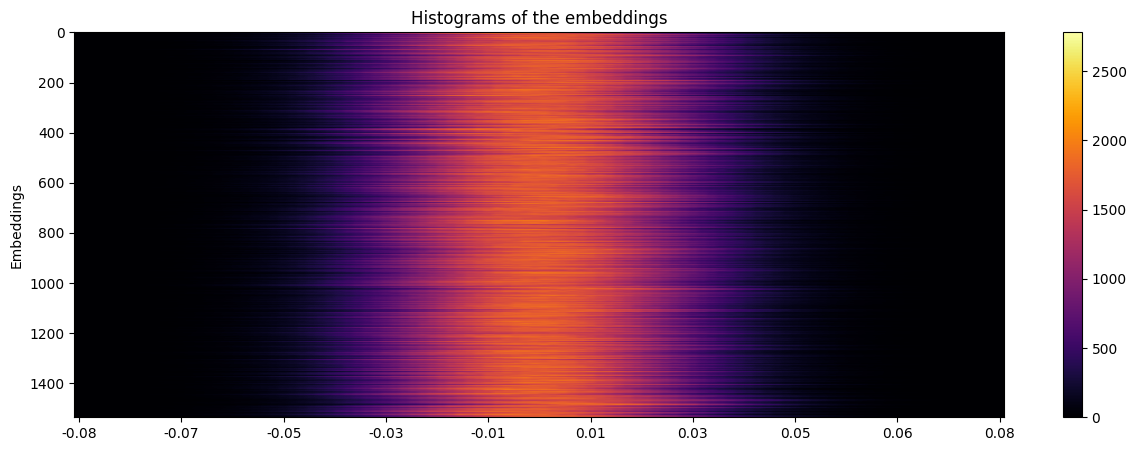

In [8]:
n_bins = 100
hists = []
frequenceies = []
for i in tqdm(range(embeddings.shape[1])):
    frequency, hist = np.histogram(embeddings[:,i], bins=n_bins)
    hists.append(hist)
    frequenceies.append(frequency)
x_ticks = np.array(hists).mean(axis=0)
plt.figure(figsize=(15, 5))
plt.imshow(frequenceies, cmap="inferno", aspect="auto")
plt.colorbar()
plt.xticks(np.arange(0, n_bins, int(n_bins*0.1)+1),
           labels=np.round(x_ticks[np.arange(0, n_bins, int(n_bins*0.1)+1)], 2))
plt.ylabel("Embeddings")
plt.title("Histograms of the embeddings")
plt.show()

In [ ]:
cos_baseline_relevant, cos_baseline_cores, fig = eval_cosine(
    df, "Baseline", core_mean_embedding, baseline_core_umap_embeddings, baseline_embeddings, core_pubs, topic, True)
#fig.write_image("LitQEval-report/pics/sr-cosine-baseline.pdf", width=800)
cos_predicted_relevant, cos_predicted_cores, fig = eval_cosine(
    df, "Predicted", core_mean_embedding, predicted_core_umap_embeddings, predicted_embeddings, core_pubs, topic, True)

The Core Publications in the Baseline publications are 0/0
The Semantically Relevant Baseline publications are 0/8169


The Core Publications in the Predicted publications are 0/0
The Semantically Relevant Predicted publications are 1/45776


In [ ]:
thresholds = np.linspace(0.4, 1, 100)
baseline_items = []
predicted_items = []
threshold_df = df.copy()
threshold_df["similarity"] = cosine_similarity(core_mean_embedding, embeddings).flatten()
for threshold in thresholds:
    n_pubs_baseline = threshold_df[(threshold_df["similarity"] >= threshold) & (
        threshold_df["Source"] == "Baseline")].shape[0]
    n_pubs_predicted = threshold_df[(threshold_df["similarity"] >= threshold) & (
        threshold_df["Source"] == "Predicted")].shape[0]

    n_core_pubs_baseline = len(set(threshold_df[(threshold_df["similarity"] >= threshold) & (
        threshold_df["Source"] == "Baseline")]["id"]).intersection(core_pubs["id"]))
    n_core_pubs_predicted = len(set(threshold_df[(threshold_df["similarity"] >= threshold) & (
        threshold_df["Source"] == "Predicted")]["id"]).intersection(core_pubs["id"]))
    baseline_items.append(
        {"threshold": threshold, "n_pubs": n_pubs_baseline, "n_core_pubs": n_core_pubs_baseline})
    predicted_items.append(
        {"threshold": threshold, "n_pubs": n_pubs_predicted, "n_core_pubs": n_core_pubs_predicted})

baseline_df = pd.DataFrame(baseline_items)
predicted_df = pd.DataFrame(predicted_items)
fig = go.Figure()
fig.add_traces([
    go.Scatter(x=baseline_df["threshold"], y=baseline_df["n_core_pubs"],
               customdata=baseline_df["n_pubs"],
               name="Baseline", mode="lines", marker_color=COLORS[1],
               hovertemplate="N Pubs: %{y} <br> N Core Pubs: %{customdata}"),

    go.Scatter(x=predicted_df["threshold"], y=predicted_df["n_core_pubs"],
               name="Predicted", mode="lines", marker=dict(color=COLORS[0]),
                customdata=predicted_df["n_pubs"],
                hovertemplate="N Pubs: %{y} <br> N Core Pubs: %{customdata}")
])
fig.update_layout(
    **PLOT_CONFIGS, title="Number of Core Publications vs Threshold", hovermode="x")
fig.show()

In [ ]:
cluster_baseline_k, cluster_baseline_relevant, cluster_baseline_core, fig = eval_clustering(
    df, "Baseline", baseline_embeddings, baseline_cp, topic, True)
# fig.write_image("LitQEval-report/pics/sr-clustering-baseline.pdf", width=800)
cluster_predicted_k, cluster_predicted_relevant, cluster_predicted_core, fig = eval_clustering(
    df, "Predicted", predicted_embeddings, predicted_cp, topic, True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


In [ ]:
if baseline_core_umap_embeddings.size != 0 and baseline_core_umap_embeddings.shape[0] >= 3:
    mvee_baseline_relevant, fig = eval_mvee(df, "Baseline", baseline_core_umap_embeddings, baseline_umap_embeddings, topic, True)
    #fig.write_image("LitQEval-report/pics/sr-mvee-baseline.pdf", width=800)

else:
    mvee_baseline_relevant = pd.DataFrame({"id": []})
if predicted_core_umap_embeddings.size != 0 and predicted_core_umap_embeddings.shape[0] >= 3:
    mvee_predicted_relevant, fig = eval_mvee(df, "Predicted", predicted_core_umap_embeddings, predicted_umap_embeddings, topic, True)
else:
    mvee_predicted_relevant = pd.DataFrame({"id": []})

In [ ]:
if baseline_core_umap_embeddings.size != 0 and baseline_core_umap_embeddings.shape[0] >= 3:
    hull_baseline_relevant, fig = eval_hull(df, "Baseline", baseline_core_umap_embeddings, baseline_umap_embeddings, topic, True)
    #fig.write_image("LitQEval-report/pics/sr-hull-baseline.pdf", width=800)

else:
    hull_baseline_relevant = pd.DataFrame({"id": []})
if predicted_core_umap_embeddings.size != 0 and predicted_core_umap_embeddings.shape[0] >= 3:
    hull_predicted_relevant, fig = eval_hull(df, "Predicted", predicted_core_umap_embeddings, predicted_umap_embeddings, topic, True)
else:
    hull_predicted_relevant = pd.DataFrame({"id": []})

In [ ]:
import numpy as np
import plotly.graph_objects as go

# To take the number of the publications into account
def decay_function(t, p=1.5, q=10):
    return (1 - t**p)**q

v = 50000  # Threshold value
temp = np.linspace(0, 50000, 100)
custom = decay_function(temp / v) 

fig = go.Figure()

fig.add_traces([
    go.Scatter(x=temp, y=custom, mode='lines'),
])

fig.update_layout(
    **PLOT_CONFIGS, title="Decay Function", xaxis_title="Number of Publications", yaxis_title="Decay value"

)
#fig.write_image("LitQEval-report/pics/decay_function.pdf")
fig.show()


In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=["Recall Effect", "Precision Effect",
                                                     "F1 Score vs Number of Publications", "Decayed Precision"],
                    vertical_spacing=0.4, horizontal_spacing=0.1)

precisions = np.linspace(0, 1, 100)
recalls = np.linspace(0, 1, 100)
n_pubs = np.linspace(0, 50000, 100)
p = 1.5
q = 10
beta = 2
decayed_presicions = [i * (1 - (n/50000)**p)**q for i, n in zip(precisions[::-1], n_pubs)]
fig.add_trace(go.Scatter(x=precisions, y=[fscore(p, 1, 5000, beta) for p in precisions], mode="lines", name="F1 Score"), row=1, col=1)
fig.add_trace(go.Scatter(x=recalls, y=[fscore(1, r, 5000, beta) for r in recalls], mode="lines", name="F1 Score"), row=1, col=2)
fig.add_trace(go.Scatter(x=n_pubs, y=[fscore(1, 1, n, beta) for n in n_pubs], mode="lines", name="F1 Score"), row=2, col=1)
fig.add_trace(go.Scatter(x=n_pubs, y=decayed_presicions, mode="lines", name="Decayed Precision"), row=2, col=2)
PLOT_CONFIGS = dict(
    title_x=0.5, title_font_size=30, title_font_family="Modern Computer", font_family="Modern Computer",
    showlegend=False, legend_title="", height=500,
    xaxis_tickfont_size=15, yaxis_tickfont_size=15, legend_font_size=20, legend_itemsizing="constant",
    legend_orientation="h", legend_yanchor="bottom", legend_y=-0.3, legend_xanchor="center", legend_x=0.5
)
fig.update_layout(**PLOT_CONFIGS, 
                      yaxis1_title="F1 Score", yaxis3_title="F1 Score", yaxis4_title="Precision",
                      xaxis1_title="Precision", xaxis2_title="Recall",
                      xaxis3_title="Number of Publications", xaxis4_title="Number of Publications")
# fig.write_image("LitQEval-report/pics/f_score.pdf")
fig.show()


In [ ]:
beta = 2

cos_baseline_precision = cos_baseline_relevant.shape[0] / len(baseline_pubs)
cos_baseline_recall = len(cos_baseline_cores) / len(core_pubs)
cos_baseline_f2 = fscore(cos_baseline_precision, cos_baseline_recall, cos_baseline_relevant.shape[0], beta)
cos_predicted_precision = cos_predicted_relevant.shape[0] / len(predicted_pubs)
cos_predicted_recall = len(cos_predicted_cores) / len(core_pubs)
cos_predicted_f2 = fscore(cos_predicted_precision, cos_predicted_recall, cos_predicted_relevant.shape[0], beta)


cluster_baseline_precision = cluster_baseline_relevant.shape[0] / len(baseline_pubs)
cluster_baseline_recall = cluster_baseline_core / len(core_pubs)
cluster_baseline_f2 = fscore(cluster_baseline_precision, cluster_baseline_recall, cluster_baseline_relevant.shape[0], beta)
cluster_predicted_precision = cluster_predicted_relevant.shape[0] / len(predicted_pubs)
cluster_predicted_recall = cluster_predicted_core / len(core_pubs)
cluster_predicted_f2 = fscore(cluster_predicted_precision, cluster_predicted_recall, cluster_predicted_relevant.shape[0], beta)

mvee_baseline_precision = mvee_baseline_relevant.shape[0] / len(baseline_pubs)
mvee_baseline_recall = 1
mvee_baseline_f2 = fscore(mvee_baseline_precision, mvee_baseline_recall, mvee_baseline_relevant.shape[0], beta)
mvee_predicted_precision = mvee_predicted_relevant.shape[0] / len(predicted_pubs)
mvee_predicted_recall = 1
mvee_predicted_f2 = fscore(mvee_predicted_precision, mvee_predicted_recall, mvee_predicted_relevant.shape[0], beta)

hull_baseline_precision = hull_baseline_relevant.shape[0] / len(baseline_pubs)
hull_baseline_recall = 1
hull_baseline_f2 = fscore(hull_baseline_precision, hull_baseline_recall, hull_baseline_relevant.shape[0], beta)
hull_predicted_precision = hull_predicted_relevant.shape[0] / len(predicted_pubs)
hull_predicted_recall = 1
hull_predicted_f2 = fscore(hull_predicted_precision, hull_predicted_recall, hull_predicted_relevant.shape[0], beta)

intersecting_baseline_relevant = set(cos_baseline_relevant["id"]).intersection(
                                set(cluster_baseline_relevant["id"]))\
                                .intersection(set(mvee_baseline_relevant["id"]))\
                                .intersection(set(hull_baseline_relevant["id"]))
intersecting_predicted_relevant = set(cos_predicted_relevant["id"]).intersection(
                                set(cluster_predicted_relevant["id"]))\
                                .intersection(set(mvee_predicted_relevant["id"]))\
                                .intersection(set(hull_predicted_relevant["id"]))

intersecting_baseline_core = intersecting_baseline_relevant.intersection(baseline_cp)
intersecting_predicted_core = intersecting_predicted_relevant.intersection(predicted_cp)

intersecting_baseline_precision = len(intersecting_baseline_relevant) / len(baseline_pubs)
intersecting_baseline_recall = len(intersecting_baseline_core) / len(core_pubs)
intersecting_baseline_f2 = fscore(intersecting_baseline_precision, intersecting_baseline_recall, len(intersecting_baseline_relevant), beta)
intersecting_predicted_precision = len(intersecting_predicted_relevant) / len(predicted_pubs)
intersecting_predicted_recall = len(intersecting_predicted_core) / len(core_pubs)
intersecting_predicted_f2 = fscore(intersecting_predicted_precision, intersecting_predicted_recall, len(intersecting_predicted_relevant), beta)

In [ ]:
print("Results Summary:")
print(f"- Predicted Recall: {round(baseline_recall, 3)} ({len(predicted_cp)}/{len(core_pubs)} core publications found)")
print(f"- Baseline Recall: {round(predicted_recall, 3)} ({len(baseline_cp)}/{len(core_pubs)} core publications found)")
print("--"*20)

print(f"- Cosine Similarity:")
print(f"• Baseline F2 Score: {cos_baseline_f2}")
print(f"  • Baseline Relevant: {cos_baseline_relevant.shape[0]}/{len(baseline_pubs)}")
print(f"  • Baseline Core: {len(cos_baseline_cores)}/{len(baseline_cp)}")
print(f"• Predicted F2 Score: {cos_predicted_f2}")
print(f"  • Predicted Relevant: {cos_predicted_relevant.shape[0]}/{len(predicted_pubs)}")
print(f"  • Predicted Core: {len(cos_predicted_cores)}/{len(predicted_cp)}")
print("--"*20)

print(f"Cluster Results:")
print(f"• Baseline F2 Score: {cluster_baseline_f2}")
print(f"  • Baseline Best K: {cluster_baseline_k}")
print(f"  • Baseline Publications in Best Cluster: {cluster_baseline_relevant.shape[0]} / {len(baseline_pubs)}")
print(f"  • Baseline Core Publications in Best Cluster: {cluster_baseline_core}/{len(baseline_cp)}")
print(f"• Predicted F2 Score: {cluster_predicted_f2}")
print(f"  • Predicted Best K: {cluster_predicted_k}")
print(f"  • Predicted Publications in Best Cluster: {cluster_predicted_relevant.shape[0]} / {len(predicted_pubs)}")
print(f"  • Predicted Core Publications in Best Cluster: {cluster_predicted_core}/{len(predicted_cp)}")
print("--"*20)


print(f"- MVEE Results:")
print(f"• Baseline F2 Score: {mvee_baseline_f2}")
print(f"  • Relevant Baseline Publications (Inside MVEE): {mvee_baseline_relevant.shape[0]} / {len(baseline_pubs)}")
print(f"• Predicted F2 Score: {mvee_predicted_f2}")
print(f"  • Relevant Predicted Publications (Inside MVEE): {mvee_predicted_relevant.shape[0]} / {len(predicted_pubs)}")
print("--"*20)

print(f"- Hull Results:")
print(f"• Baseline F2 Score: {hull_baseline_f2}")
print(f"  • Relevant Baseline Publications (Inside Hull): {hull_baseline_relevant.shape[0]} / {len(baseline_pubs)}")
print(f"• Predicted F2 Score: {hull_predicted_f2}")
print(f"  • Relevant Predicted Publications (Inside Hull): {hull_predicted_relevant.shape[0]} / {len(predicted_pubs)}")
print("--"*20)


print(" - Aggregated Results:")
print(f"• Baseline F2 Score: {intersecting_baseline_f2}")
print(f"  • Baseline: {len(intersecting_baseline_relevant)}/{len(baseline_pubs)}")
print(f"  • Baseline Core: {len(intersecting_baseline_core)}/{len(baseline_cp)}")
print(f"• Predicted F2 Score: {intersecting_predicted_f2}")
print(f"  • Predicted: {len(intersecting_predicted_relevant)}/{len(predicted_pubs)}")
print(f"  • Predicted Core: {len(intersecting_predicted_core)}/{len(predicted_cp)}")



Results Summary:
- Predicted Recall: 0.0 (0/27 core publications found)
- Baseline Recall: 0.0 (0/27 core publications found)
----------------------------------------
- Cosine Similarity:
• Baseline F2 Score: 0
  • Baseline Relevant: 0/8169
  • Baseline Core: 0/0
• Predicted F2 Score: 0
  • Predicted Relevant: 1/45776
  • Predicted Core: 0/0
----------------------------------------
Cluster Results:
• Baseline F2 Score: 0
  • Baseline Best K: 0
  • Baseline Publications in Best Cluster: 0 / 8169
  • Baseline Core Publications in Best Cluster: 0/0
• Predicted F2 Score: 0
  • Predicted Best K: 0
  • Predicted Publications in Best Cluster: 0 / 45776
  • Predicted Core Publications in Best Cluster: 0/0
----------------------------------------
- MVEE Results:
• Baseline F2 Score: 0
  • Relevant Baseline Publications (Inside MVEE): 0 / 8169
• Predicted F2 Score: 0
  • Relevant Predicted Publications (Inside MVEE): 0 / 45776
----------------------------------------
- Hull Results:
• Baseline F